<a href="https://colab.research.google.com/github/MHubAI/examples/blob/main/notebooks/PW41_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MHub Universal Notebook

This notebook demonstrates how to run models from [MHub.ai](https://mhub.ai) using [Imaging Data Commons (IDC)](https://portal.imaging.datacommons.cancer.gov/) data.

MHub is a novel platform, providing standardized medical imaging models with a harmonized I/O interface. MHub models are originally containerized to provide platform agnostic models that can be run locally or in the cloud without additional environmental setup. However, as it is not possible to run Docker images from within a Colab notebook, we instead setup the environment in the notebook based on the instructions outlined in the Dockerfile.


## Disclaimer

The code and data of this repository are provided to promote reproducible research. They are not intended for clinical care or commercial use.

The software is provided "as is", without warranty of any kind, express or implied, including but not limited to the warranties of merchantability, fitness for a particular purpose and noninfringement. In no event shall the authors or copyright holders be liable for any claim, damages or other liability, whether in an action of contract, tort or otherwise, arising from, out of or in connection with the software or the use or other dealings in the software.

# Global Variables


In [ ]:
from IPython.display import display

We specify set the default MHub model the notebook will be running if the user doesn't want to interact with the model selection dropdown.

In [ ]:
MHUB_MODEL_NAME = "lungmask"       # @param {type:"string"}
MHUB_IN = "/content/data/dicom"    # @param {type:"string"}
MHUB_OUT = "/content/results"      # @param {type:"string"}

# Notebook Setup

Let's start by installing all the dependencies needed for this project.

We install `ipywidgets` and `itkwidgets` to display interactive controls and visualize medical images in the notebook. Then we install `idc-index`, a convenient python utility to download patient data from IDC.

As mentioned earlier, all MHub models are usually run in a Docker container. However, Docker cannot be installed under certain circumstances (e.g., lacking root access) as we're facing in this notebook. We will use a python library called `udocker` to run the MHub containers instead. Note, that the run commands are slightly different but compatible in general. For further information please refer to the [udocker documentation](https://indigo-dc.github.io/udocker/user_manual.html) and the [how to run a model article](https://github.com/MHubAI/documentation/blob/main/documentation/mhub/run_mhub.md) in the [MHub documentation](https://github.com/MHubAI/documentation).

*If you want to open the `/content` folder, click the following link: /content/../content*

## UDocker Setup

udocker is a Python implementation that alows running any MHub docker container in an environment without root access and without requireing Docker to be installed.

In [ ]:
%%capture
!pip install udocker

Running the model on a GPU can substantially speed up the computaion. Some models might not work without a suitable GPU. We can utilize GPU acceleration when a Nvidia GPU is available in this notebook. You can run the `nvidia-smi` command to test for GPU availability.

In [ ]:
# check GPU access
!nvidia-smi

If the above command runs we have a GPU and con continue installing the nvidia tooklit into the notebook.

In [ ]:
%%capture
!apt-get install -y nvidia-container-toolkit

Finally, we install a helper script that helps to convert between docker and udocker cli syntax.

In [ ]:
%%capture
!wget https://gist.githubusercontent.com/LennyN95/00c28299d1042326a544a6508e8920b0/raw/ -O ./docker.sh
!chmod +x ./docker.sh
!mv ./docker.sh /usr/bin/docker

## Python Setup

In [ ]:
%%capture

# install ipywidgets
!pip install --upgrade google-colab
!pip install ipywidgets
!pip install itkwidgets[all]==1.0a35

# install idc-index
!pip install --upgrade idc-index

# install dcmqi
!pip install itk
!pip install SimpleITK
!pip install dcmqi

# install yaml support
!pip install yamlmagic
!pip install pyaml

Load notebook extensions.

In [ ]:
%load_ext yamlmagic

Import all Python libraries used throughout this notebook.

In [ ]:
import subprocess
import os
import time
import json

import ipywidgets as widgets

from urllib.request import urlopen
from google.colab import files

# Select the MHub Model

MHub hosts several pre-trained models for the analysis of CT scans, all of which are harmonized and share a common interface - so you can swap models by simply swapping model names in the run command!

You can learn more about all the models (including the data they have been trained and evaluated on) by visiting the https://mhub.ai/models page.

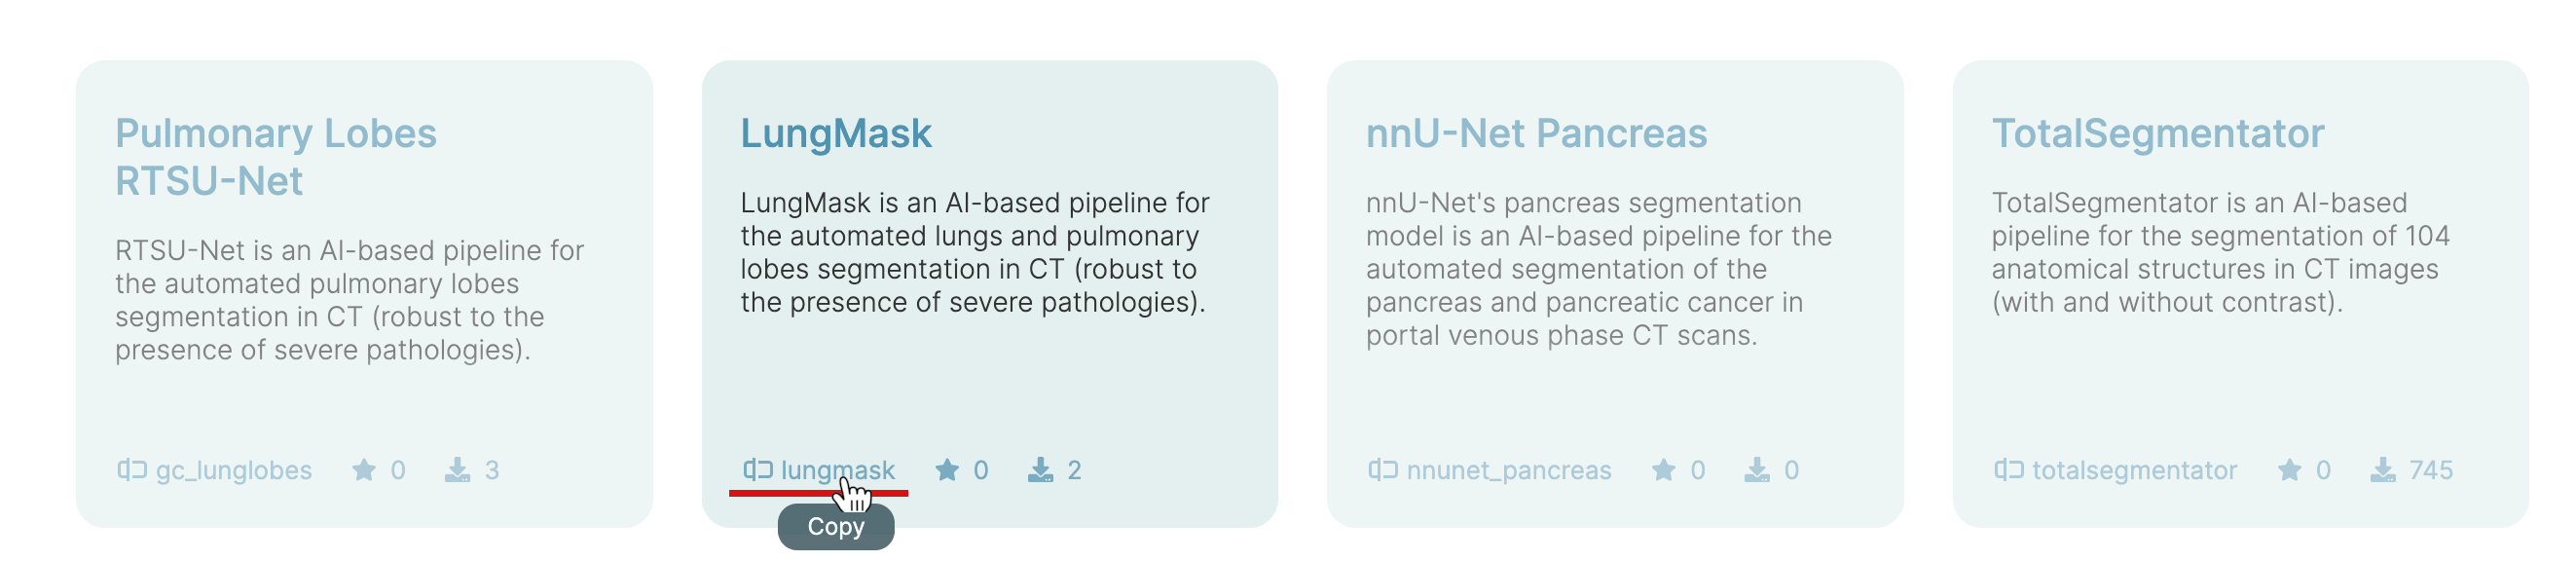

---

<br>

We can fetch a list of all available MHub models through the MHub.ai API.

Running the following two cells will spawn a dropdown box where you can select the model you would like to run in the notebook.

In [ ]:
# fetch the mhub.ai api
MHUBAI_MODELS_ENDPOINT = "https://mhub.ai/api/v2/models"

# fetch information on the models on the platform
models = json.loads(urlopen(MHUBAI_MODELS_ENDPOINT).read())['data']['models']

# generate model picker
model_picker = widgets.Dropdown(options=models, value=MHUB_MODEL_NAME)

In [ ]:
# display model picker
display(model_picker)

In [ ]:
# update model name environment variable and display selection
MHUB_MODEL=model_picker.value
print("Selected Model: ", MHUB_MODEL)

# Model Environment Setup

The next series of cell will take care of the model environment set-up. This process is essentially automated, and closely mimicks what happens inside an MHub container. We start by cloning the model folder from the MHub [Models Repository](https://github.com/MHubAI/models), based on the model selection made earlier.

We then extract the base Dockerfile and the Dockerfile of the model and pass both to our helper function `setup_environment`, which reads the Dockerfiles and sets up the environment accordingly.

**NOTE**: This step can take up to several minutes since setting up the environment involves downloading model weights with large file sizes.

In [ ]:
# setup container
%%capture
!udocker --allow-root pull mhubai/$MHUB_MODEL:latest
!udocker --allow-root create --name=$MHUB_MODEL mhubai/$MHUB_MODEL:latest
!udocker --allow-root setup --nvidia --force $MHUB_MODEL

In [ ]:
# change workding directory
!cd /content/

In [ ]:
# directory setup
!rm -r /content/sample_data
!mkdir -p $MHUB_IN $MHUB_OUT

# Load Example Data from IDC

Now that the model environment is set up, it's time to download some data.

In [ ]:
SERIES_INSTANCE_UID="1.2.840.113654.2.55.229650531101716203536241646069123704792"

In [ ]:
!idc download-from-selection --series-instance-uid $SERIES_INSTANCE_UID --download-dir $MHUB_IN

We can use the IDC Radiology Image Viewer to visualize the series and study of interest.

In [ ]:
from idc_index import IDCClient

idc_client = IDCClient()
viewer_url = idc_client.get_viewer_URL(seriesInstanceUID=SERIES_INSTANCE_UID)

print("URL to view the specific series:")
print(viewer_url)

# Run the MHub Model

The only thing that is left to do is to run the MHub model

MHub provides a simple and standard interface: `python3 -m mhubio.run`. With the `python3 -m` option, we can start a Python module `mhubio.run` that takes care of running the MHub workflow. Each MHub model has a default workflow that processes DICOM data and generates DICOM compatible data (e.g. DICOMSEG for segmentation models).

We will show you later how to create your own custom workflows by writing a custom configuration. Different workflows can be specified using the `--workflow` argument. To run the `default` workflow, the user can simply use `--workflow default`.

Once the workflow is finished, we can move the generated output data from the output folder `/app/data/output_data` into our content folder at `/content/data/processed`.



In [ ]:
!docker run -t --gpus all --network=none \
  -v $MHUB_IN:/app/data/input_data \
  -v $MHUB_OUT:/app/data/output_data \
  $MHUB_MODEL --workflow default --debug --print

# Inspect the Results

Finally, we can interact with the data we generated in different ways.

We can visualise the raw AI-generated segmentation masks directly in the notebook by using the utilities developed as part of the `itkwidgets` library.

In [ ]:
import itk
import SimpleITK as sitk
from itkwidgets import view

In [ ]:
dicomseg_file = os.path.join(MHUB_OUT, SERIES_INSTANCE_UID, f"{MHUB_MODEL}.seg.dcm")
assert os.path.isfile(dicomseg_file), f"{dicomseg_file} not found."

In [ ]:
nrrd_path = "data/processed_nrrd"

%mkdir -p $nrrd_path

!segimage2itkimage --inputDICOM $dicomseg_file \
  --outputType nrrd \
  --prefix segment \
  --outputDirectory $nrrd_path \
  --mergeSegments

In [ ]:
merged_mask = None

# Iterate over all the .nrrd files (segments) exported by DCMQI
for filename in os.listdir(nrrd_path):
    if filename.endswith(".nrrd"):
        file_path = os.path.join(nrrd_path, filename)
        mask = sitk.ReadImage(file_path)

        if merged_mask is None:
            merged_mask = mask
        else:
            merged_mask = merged_mask + mask

# Save the merged mask
path_to_merged_mask = os.path.join(nrrd_path, "merged_mask.nrrd")
sitk.WriteImage(merged_mask, path_to_merged_mask)

In [ ]:
merged_mask = itk.imread(path_to_merged_mask)
viewer = view(label_image=merged_mask)

viewer.set_image_gradient_opacity(0.4)
viewer.set_label_image_blend(0.8)
viewer.set_background_color([0.25,0.25,0.25])
viewer.set_label_image_weights([0, 1])

We can also visualize the CT scan together with the segmentation labels.

Note: this could take a little bit longer to render!

In [ ]:
image = itk.imread("/content/data/dicom/nlst/100002/1.2.840.113654.2.55.68425808326883186792123057288612355322/CT_1.2.840.113654.2.55.229650531101716203536241646069123704792")

viewer = view(image, label_image=merged_mask)

viewer.set_background_color([0.0,0.0,0.0])

---
For further analysis, we can download the DICOM Series used for segmentation and the results of the MHub segmentation model we selected.

These data can be then inspected locally with a viewer of our choice (e.g., 3DSlicer).

In [ ]:
%%capture

archive_fn = "%s-%s.zip"%(SERIES_INSTANCE_UID, MHUB_MODEL)

try:
  os.remove(archive_fn)
except OSError:
  pass

!zip -j -r $archive_fn $dicomseg_file /content

In [ ]:
filesize = os.stat(os.path.join("/content", archive_fn)).st_size/1024e03
print('Starting the download of "%s" (%2.1f MB)...\n'%(archive_fn, filesize))

files.download(archive_fn)

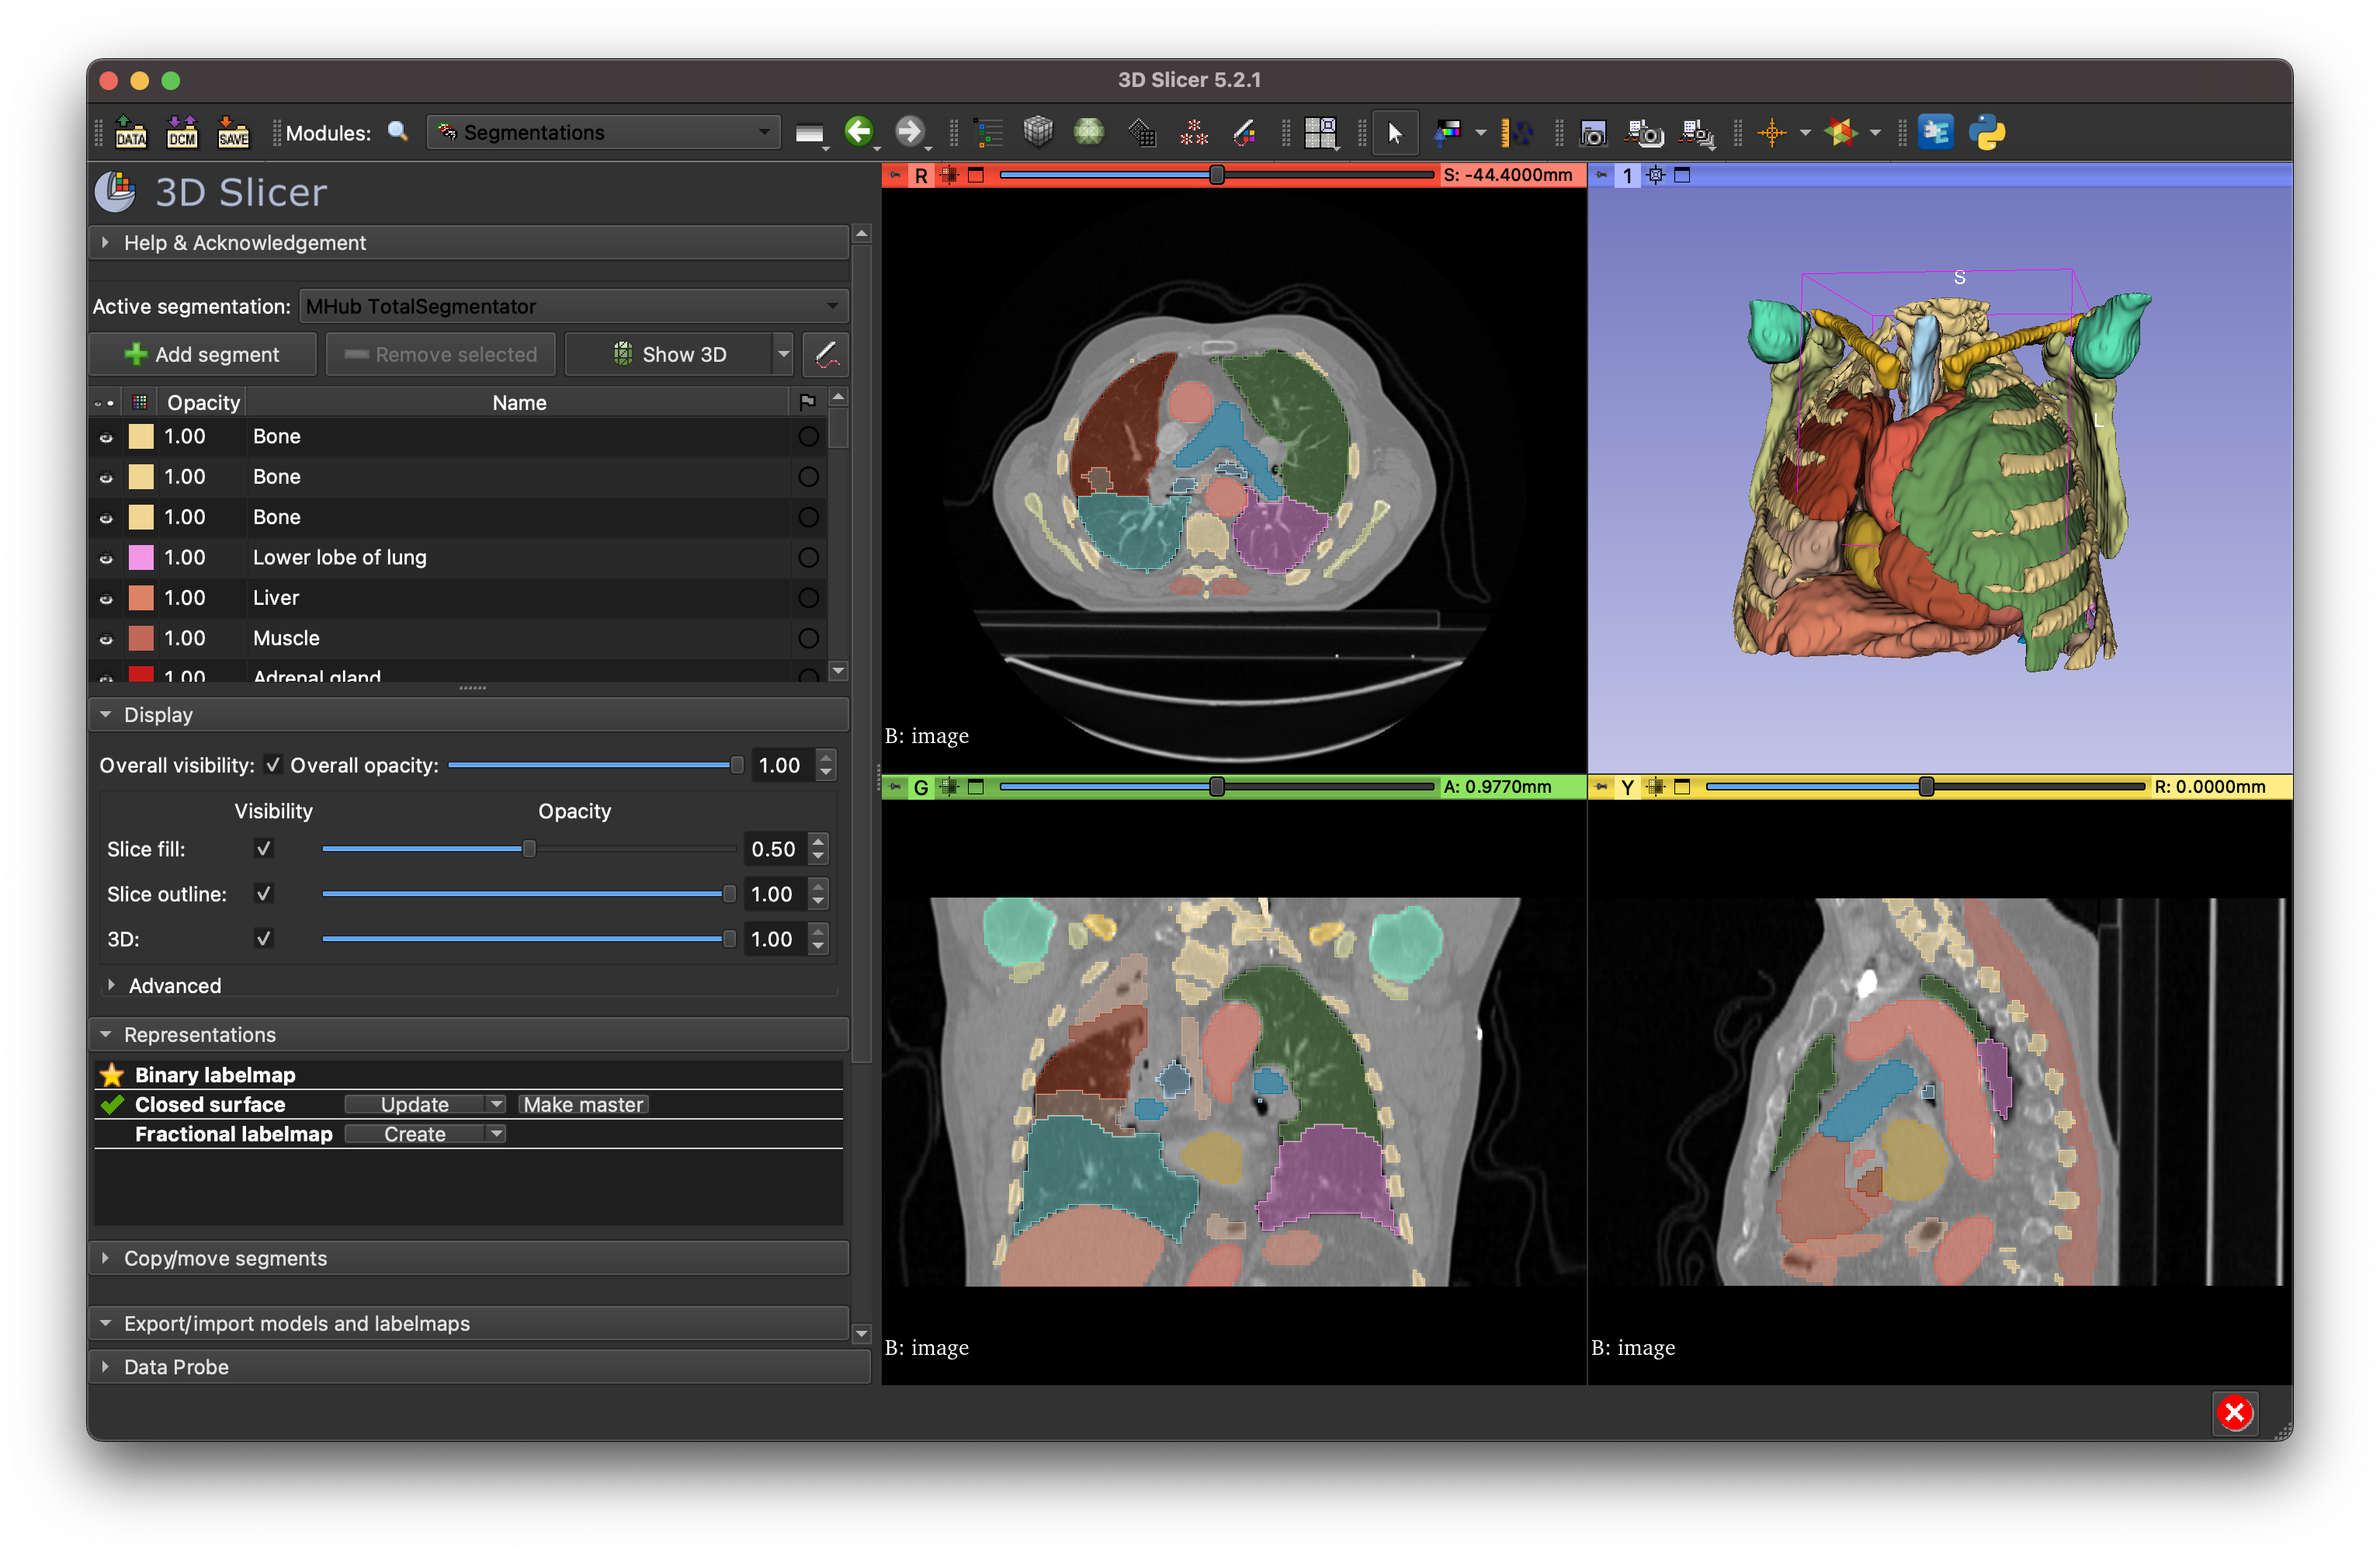

## Custom Workflow

For full customizability you can also create a custom MHub workflow and run this instead.

### Workflow Configuration File

In [ ]:
%%yaml workflow
general:
  data_base_dir: /app/data
  version: 1.0
  description: custom configuration that sorts and converts dicom to nifti

execute:
- DicomImporter
- NiftiConverter
- DataOrganizer

modules:
  DicomImporter:
    source_dir: input_data
    import_dir: sorted_data
    sort_data: true
    meta:
      mod: '%Modality'

  DataOrganizer:
    targets:
    - nifti-->nifti/[i:sid]/image.nii.gz

### Run Command

In [ ]:
!docker run -t -v $MHUB_IN:/app/data/input_data -v $MHUB_OUT:/app/data/output_data --gpus all --network=none $MHUB_MODEL --debug --print <<< "$workflow"

## Support

If you have any questions about this notebook, please post them in the [IDC User Forum](https://discourse.canceridc.dev).

## Acknowledgments

Imaging Data Commons has been funded in whole or in part with Federal funds from the National Cancer Institute, National Institutes of Health, under Task Order No. HHSN26110071 under Contract No. HHSN261201500003l.

If you use IDC in your research, please cite the following publication:

> Fedorov, A., Longabaugh, W. J. R., Pot, D., Clunie, D. A., Pieper, S. D., Gibbs, D. L., Bridge, C., Herrmann, M. D., Homeyer, A., Lewis, R., Aerts, H. J. W., Krishnaswamy, D., Thiriveedhi, V. K., Ciausu, C., Schacherer, D. P., Bontempi, D., Pihl, T., Wagner, U., Farahani, K., Kim, E. & Kikinis, R. _National Cancer Institute Imaging Data Commons: Toward Transparency, Reproducibility, and Scalability in Imaging Artificial Intelligence_. RadioGraphics (2023). [https://doi.org/10.1148/rg.230180](https://doi.org/10.1148/rg.230180)